#Importing Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, layers

In [2]:
train_files_healthy = "crop-images/Train/Train/Healthy"
train_files_powdery = "crop-images/Train/Train/Powdery"
train_files_rust = "crop-images/Train/Train/Rust"
training_files = "crop-images/Train/Train"

test_files_healthy = "crop-images/Test/Test/Healthy"
test_files_powdery = "crop-images/Test/Test/Powdery"
test_files_rust = "crop-images/Test/Test/Rust"
test_files = "crop-images/Test/Test"

valid_files_healthy = "crop-images/Validation/Validation/Healthy"
valid_files_powdery = "crop-images/Validation/Validation/Powdery"
valid_files_rust = "crop-images/Validation/Validation/Rust"
valid_files = "crop-images/Validation/Validation"

In [29]:
image_width = 167
image_height = 250
batch_size_const = 32

In [30]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    training_files,
    shuffle = True, 
    image_size = (image_width , image_height),
    batch_size = batch_size_const)

Found 1322 files belonging to 3 classes.


In [31]:
class_names = dataset.class_names
class_names

['Healthy', 'Powdery', 'Rust']

In [32]:
len(dataset) #total batches

42

In [33]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy()) #converted to array as it is a tensor

(32, 167, 250, 3)
[1 0 0 2 2 0 2 2 2 1 0 0 1 0 0 0 0 2 0 1 2 1 0 1 0 0 2 1 2 1 0 0]


#Displaying Images

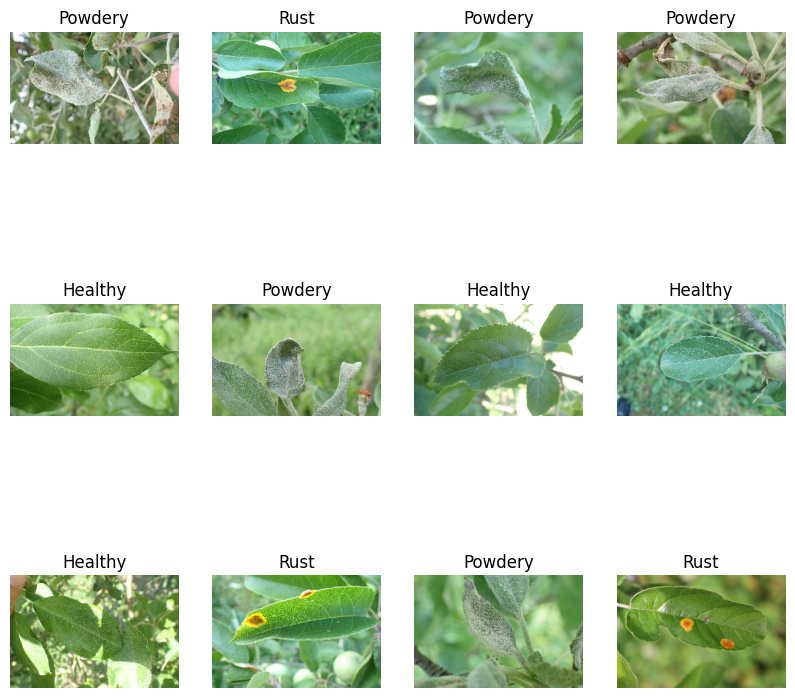

In [35]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

#Train , Test and Validation

In [37]:
# 80 -> Training
# 10 -> Testing
# 10 -> Validation

In [54]:
def dataset_partition(ds,train=0.8,val=0.1,test=0.1,shuffle = True, shuffle_size=10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size , seed = 10)
    
    train_size = int(train * ds_size)
    val_size = int(val * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds , val_ds, test_ds

In [55]:
train_ds , val_ds , test_ds = dataset_partition(dataset)

In [57]:
len(train_ds) #for size confirmation - 42*0.8 ~ 33

33

In [58]:
#keeps image in memory , helps to improve performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#Preprocessing

In [61]:
resize_rescalling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_width , image_height),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data Augumentation

In [63]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

#Model

In [72]:
channels = 3
input_sh = (batch_size_const,image_width,image_height,channels)
n_classes = 3
model = models.Sequential([
    resize_rescalling,
    data_aug,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_sh),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_sh)

In [73]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 167, 250, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 167, 250, 3)         0         
                                                                 
 conv2d_30 (Conv2D)          (32, 165, 248, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPooli  (32, 82, 124, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (32, 80, 122, 64)         18496     
                                                                 
 max_pooling2d_31 (MaxPooli  (32, 40, 61, 64)          0         
 ng2D)                                                

In [74]:
model.compile(optimizer = "adam",
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics = ['accuracy'])

In [75]:
history = model.fit(train_ds,
                   epochs = 50,
                   batch_size = batch_size_const,
                   verbose = 1,
                   validation_data=val_ds)

Epoch 1/50
33/33 [==============================] - 30s 573ms/step - loss: 0.9874 - accuracy: 0.4797 - val_loss: 0.9182 - val_accuracy: 0.5938
Epoch 2/50
33/33 [==============================] - 13s 397ms/step - loss: 0.6396 - accuracy: 0.6867 - val_loss: 0.6140 - val_accuracy: 0.7188
Epoch 3/50
33/33 [==============================] - 13s 394ms/step - loss: 0.4977 - accuracy: 0.8046 - val_loss: 0.2745 - val_accuracy: 0.9062
Epoch 4/50
33/33 [==============================] - 13s 393ms/step - loss: 0.3708 - accuracy: 0.8733 - val_loss: 0.2524 - val_accuracy: 0.9297
Epoch 5/50
33/33 [==============================] - 13s 394ms/step - loss: 0.3377 - accuracy: 0.8907 - val_loss: 0.2217 - val_accuracy: 0.9219
Epoch 6/50
33/33 [==============================] - 13s 394ms/step - loss: 0.2209 - accuracy: 0.9255 - val_loss: 0.3303 - val_accuracy: 0.8906
Epoch 7/50
33/33 [==============================] - 13s 392ms/step - loss: 0.2483 - accuracy: 0.9149 - val_loss: 0.2834 - val_accuracy: 0.8984

In [76]:
model.evaluate(test_ds)

5/5 [==============================] - 5s 79ms/step - loss: 0.1897 - accuracy: 0.9688


[0.1896553933620453, 0.96875]

In [80]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

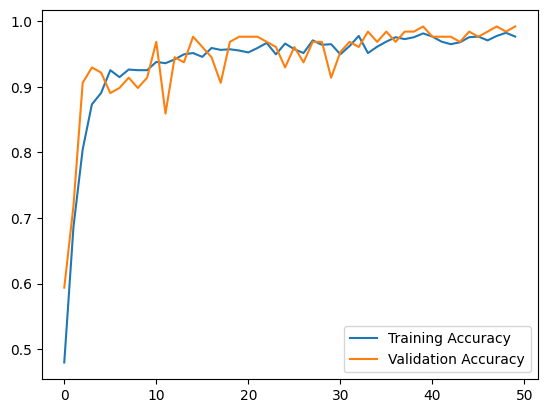

In [83]:
plt.plot(range(50),train_acc,label='Training Accuracy')
plt.plot(range(50),val_acc,label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

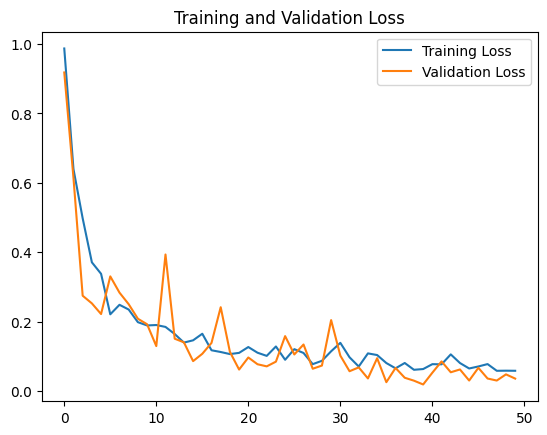

In [86]:
plt.plot(range(50),train_loss,label='Training Loss')
plt.plot(range(50),val_loss,label='Validation Loss')
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")

first image to predict
actual label: Powdery
1/1 [==============================] - 0s 94ms/step
predicted label: Powdery


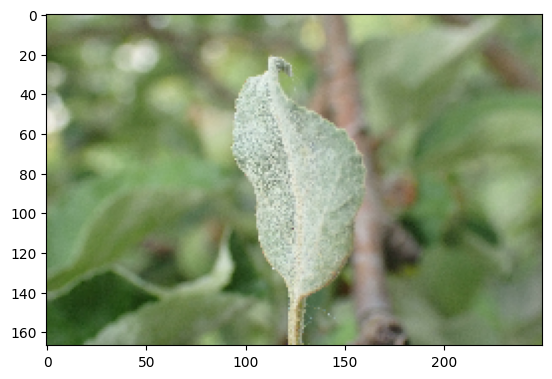

In [97]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [98]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


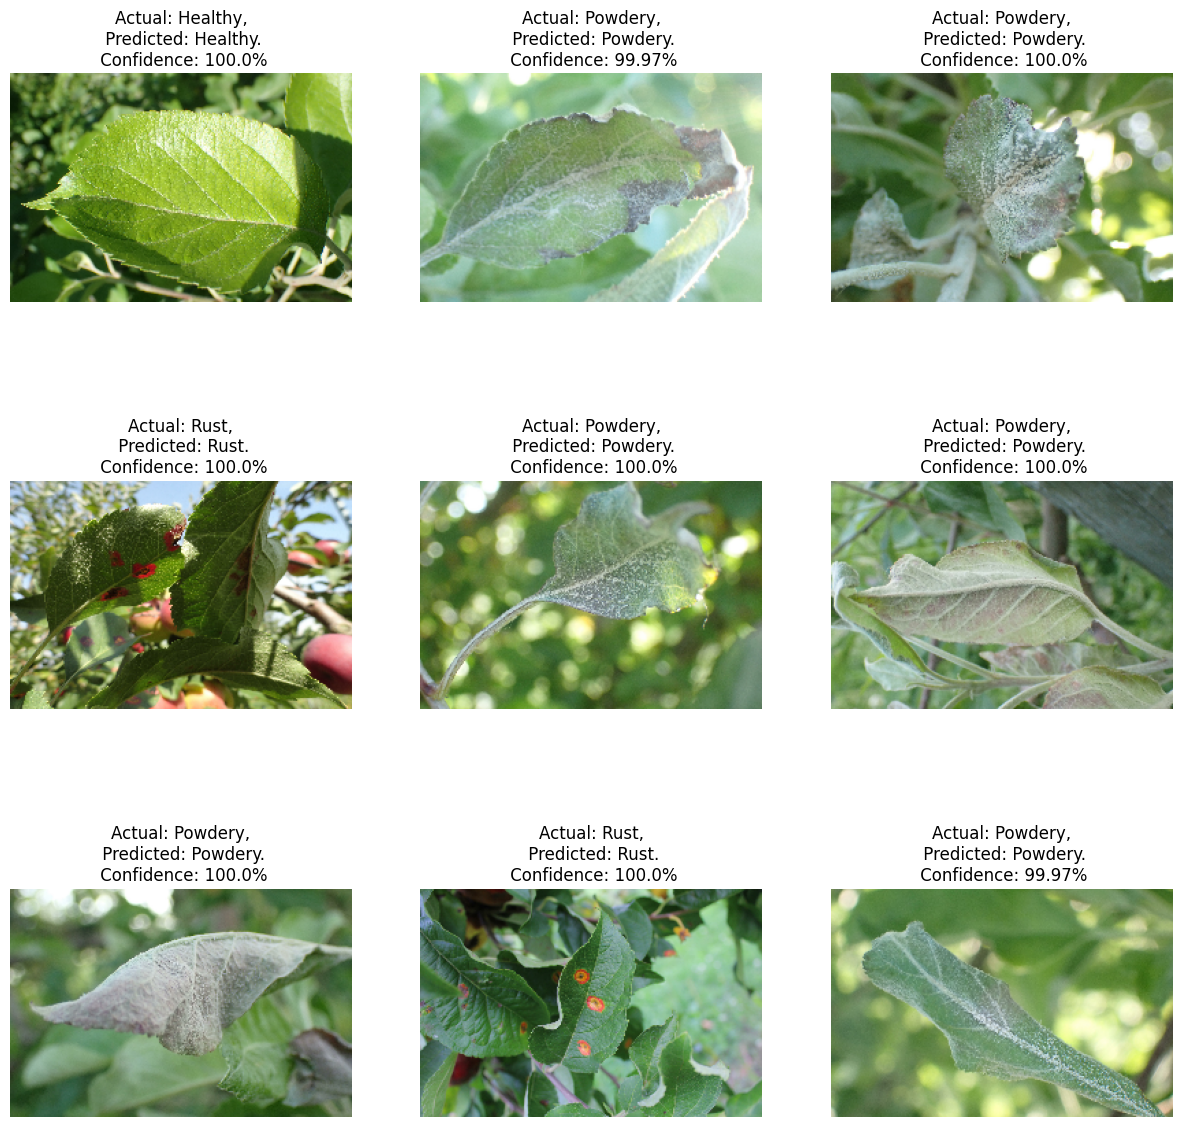

In [100]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#Saving the Model

In [103]:
model.save("crop-det-cnn.h5")

C:\Users\ASHMAN SODHI\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
